Motivation: to use a patiant's physical and clinical health indicators to determine whether the individual is suffering from a heart disease.

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [37]:
root_dir = './'
work_dir = os.getcwd() + '/'
data_loc = work_dir + 'Heart_disease_cleveland.csv'

In [38]:
df = pd.read_csv(data_loc)
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   0       145   233    1        2      150      0      2.3      2   
1   67    1   3       160   286    0        2      108      1      1.5      1   
2   67    1   3       120   229    0        2      129      1      2.6      1   
3   37    1   2       130   250    0        0      187      0      3.5      2   
4   41    0   1       130   204    0        2      172      0      1.4      0   

   ca  thal  target  
0   0     2       0  
1   3     1       1  
2   2     3       1  
3   0     1       0  
4   0     1       0

Check for the Null entries in the dataframe and if existed, handle them appropriately.

In [39]:
def manage_null(df,feature='',handle=''):
    
    feature_names = list(df.columns.values)
    feature_index = feature_names.index(feature)
    
    if handle == 'drop':
        # drop the column named 'feature'
        mod_df = df.drop(feature, inplace=False, axis=1)
    elif handle == 'mode':
        # replace null entries in column number == feature_index with the mode within the same column.
        mod_df = df.fillna(df.iloc[:,feature_index].mode()[0], inplace=False)
    elif handle == 'mean':
        # replace null entries in column number == feature_index with the mean value of the column.
        mod_df = df.fillna(df.iloc[:,feature_index].mean(), inplace=False)
    else:
        print(f"Handle {handle} not found.")
        return df
    
    return mod_df

It is known that under the <b>thal</b> feature, <b>0</b>'s are tantamount to Null. We first replace them with numpy's NaN and then handle them using <b>manage_null()</b>.

In [40]:
df.thal = df.thal.replace(0,np.NaN)
df = manage_null(df,'thal','mode')
df.tail()
df.shape

(303, 14)

A few definitions:

In [41]:
classes = np.unique(df.iloc[:,-1].values)
feature_names = list(df.columns.values)
feature_names.pop() # drop the last item, i.e. 'target', from the list

x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = y.reshape(-1,1)

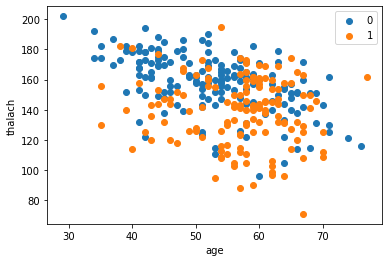

In [42]:
fig, ax = plt.subplots()
for cl in range(len(classes)):
    ax.scatter(df[feature_names[0]].loc[df["target"]==cl],
              df[feature_names[7]].loc[df["target"]==cl],
              label=classes[cl])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[7])
ax.legend(loc='upper right')

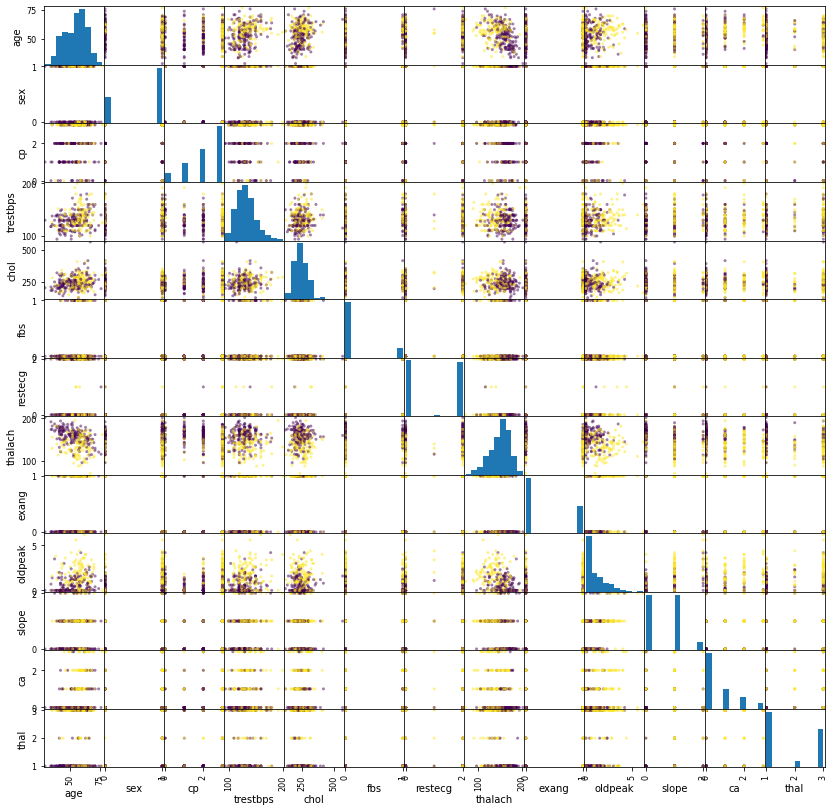

In [22]:
df_ = pd.DataFrame(x, columns=feature_names)
axs = pd.plotting.scatter_matrix(df_,c=y,figsize=(14, 14))

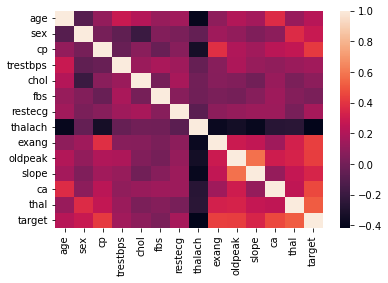

In [23]:
dataplot = sns.heatmap(df.corr())

Artificial Neural Network, with sequential dense layers.

In [56]:
# Model configuration
no_epochs = 100
no_classes = len(classes)
test_size = .2
validation_split = 0.2
verbosity = 0
rand_state = 1

# Load dataset
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = test_size, random_state = rand_state)

# Create the model
model = Sequential()
model.add(tf.keras.Input(shape=(13,)))
model.add(tf.keras.layers.Normalization(axis=-1))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit data to the model
model.fit(x_train, y_train,
          epochs=no_epochs,
          verbose=verbosity
)

# Generate generalization metrics
print("Sequential model:\n")
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")

/home/alireza/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Sequential model:

Test loss: 0.4832426607608795 / Test accuracy: 0.8032786846160889


Logistic regression

In [61]:
lr_model = LogisticRegression()
lr_model.max_iter = 200
lr_model.fit(x_train,y_train)
y_pred = lr_model.predict(x_test)
y_pred = y_pred.reshape(-1,1)

print(f"{lr_model}:\n")
print(f"Generalization metric: {lr_model.score(x,y)}\n")
print(f"Classification report:\n{metrics.classification_report(y_test, y_pred)}")
print(f"Confusion matrix:\n{metrics.confusion_matrix(y_test, y_pred)}")

LogisticRegression(max_iter=200):

Generalization metric: 0.8613861386138614

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.84      0.78      0.81        27

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

Confusion matrix:
[[30  4]
 [ 6 21]]


/home/alireza/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alireza/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
